# Load in the Dataset + Packages

In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import pickle as pkl

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import make_pipeline

from imblearn.over_sampling import SMOTE

In [2]:
# Load list of selected features
with open ('../../models/select_features', 'rb') as fp:
    select_features = pkl.load(fp)

In [3]:
# Load data from excel
train_df = pd.read_excel("../../data/processed/train_essentials.xlsx")
train_df.head()

,is_pii,is_fii,NRI score,authentication_processed,usage_base_processed,AI & Data Science,Business & Technology,Environment & Weather,Finance & Banking,GeoInformatics & Navigation,...,content-type,set-cookie,access-control-allow-origin,server,x-powered-by,x-aspnet-version,x-ratelimit-limit,metadata_fields_count,parameters_count,Risk_Label
0,True,False,77.850013,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,2,2,Low
1,True,False,77.850013,1,2,0,0,0,0,0,...,0,0,0,1,0,0,0,6,1,Low
2,False,False,76.479613,1,2,0,1,0,0,0,...,0,0,0,1,0,0,0,3,1,Medium
3,True,False,76.479613,1,2,0,0,0,0,0,...,1,0,0,0,0,0,0,5,0,Low
4,True,False,77.850013,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,2,3,Low


In [4]:
train_df.shape

(1316, 53)

In [5]:
# X, y split for train-set
X_train, y_train = train_df.drop(columns=["Risk_Label"]), train_df["Risk_Label"]

In [6]:
X_train_select = X_train[select_features]

In [7]:
y_train.value_counts()

Medium    661
Low       651
High        4
Name: Risk_Label, dtype: int64

In [8]:
# Smote function
def create_smote(X, y, k_neighbors):
    oversample = SMOTE(k_neighbors = k_neighbors)
    X, y = oversample.fit_resample(X, y)
    return X, y

In [9]:
# Balance training data
X_train, y_train = create_smote(X_train_select, y_train, 2)

# Helper Code

In [10]:
results = {}
scoring_metric = ["accuracy", "f1_macro", "recall_macro"]

In [11]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

# Baseline Performance

In [12]:
# Dummy Classifier Model
model_dummy = DummyClassifier(strategy="stratified", random_state=42)
results["Dummy"] = mean_std_cross_val_scores(
    model_dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Dummy
fit_time,0.003 (+/- 0.007)
score_time,0.007 (+/- 0.008)
test_accuracy,0.342 (+/- 0.019)
train_accuracy,0.331 (+/- 0.010)
test_f1_macro,0.342 (+/- 0.019)
train_f1_macro,0.331 (+/- 0.010)
test_recall_macro,0.342 (+/- 0.019)
train_recall_macro,0.331 (+/- 0.010)


In [13]:
# KNN Classifier Model
pipe_knn = make_pipeline(StandardScaler(), KNeighborsClassifier())
results["KNN"] = mean_std_cross_val_scores(
    pipe_knn, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Dummy,KNN
fit_time,0.003 (+/- 0.007),0.008 (+/- 0.008)
score_time,0.007 (+/- 0.008),0.021 (+/- 0.009)
test_accuracy,0.342 (+/- 0.019),0.996 (+/- 0.004)
train_accuracy,0.331 (+/- 0.010),0.998 (+/- 0.001)
test_f1_macro,0.342 (+/- 0.019),0.996 (+/- 0.004)
train_f1_macro,0.331 (+/- 0.010),0.998 (+/- 0.001)
test_recall_macro,0.342 (+/- 0.019),0.996 (+/- 0.004)
train_recall_macro,0.331 (+/- 0.010),0.998 (+/- 0.001)


In [14]:
# SVM Classifier Model
pipe_svm = make_pipeline(StandardScaler(), SVC(gamma=0.01))
results["SVM"] = mean_std_cross_val_scores(
    pipe_svm, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Dummy,KNN,SVM
fit_time,0.003 (+/- 0.007),0.008 (+/- 0.008),0.026 (+/- 0.010)
score_time,0.007 (+/- 0.008),0.021 (+/- 0.009),0.016 (+/- 0.000)
test_accuracy,0.342 (+/- 0.019),0.996 (+/- 0.004),0.995 (+/- 0.003)
train_accuracy,0.331 (+/- 0.010),0.998 (+/- 0.001),0.995 (+/- 0.001)
test_f1_macro,0.342 (+/- 0.019),0.996 (+/- 0.004),0.995 (+/- 0.003)
train_f1_macro,0.331 (+/- 0.010),0.998 (+/- 0.001),0.995 (+/- 0.001)
test_recall_macro,0.342 (+/- 0.019),0.996 (+/- 0.004),0.995 (+/- 0.003)
train_recall_macro,0.331 (+/- 0.010),0.998 (+/- 0.001),0.995 (+/- 0.001)


In [15]:
# Logistic Regression Classifier Model
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression())
results["LR"] = mean_std_cross_val_scores(
    pipe_lr, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Dummy,KNN,SVM,LR
fit_time,0.003 (+/- 0.007),0.008 (+/- 0.008),0.026 (+/- 0.010),0.022 (+/- 0.009)
score_time,0.007 (+/- 0.008),0.021 (+/- 0.009),0.016 (+/- 0.000),0.003 (+/- 0.007)
test_accuracy,0.342 (+/- 0.019),0.996 (+/- 0.004),0.995 (+/- 0.003),0.997 (+/- 0.003)
train_accuracy,0.331 (+/- 0.010),0.998 (+/- 0.001),0.995 (+/- 0.001),0.997 (+/- 0.001)
test_f1_macro,0.342 (+/- 0.019),0.996 (+/- 0.004),0.995 (+/- 0.003),0.997 (+/- 0.003)
train_f1_macro,0.331 (+/- 0.010),0.998 (+/- 0.001),0.995 (+/- 0.001),0.997 (+/- 0.001)
test_recall_macro,0.342 (+/- 0.019),0.996 (+/- 0.004),0.995 (+/- 0.003),0.997 (+/- 0.003)
train_recall_macro,0.331 (+/- 0.010),0.998 (+/- 0.001),0.995 (+/- 0.001),0.997 (+/- 0.001)


# Hyperparameter Optimization

In [16]:
# Hyperparameter search for LogisticRegression
param_grid = {"logisticregression__C": [100, 10, 1.0, 0.1, 0.01],
             "logisticregression__solver": ['newton-cg', 'lbfgs', 'liblinear']}

grid_search = GridSearchCV(
    pipe_lr, param_grid, cv=20, n_jobs=-1, return_train_score=True
)
results_gs = grid_search.fit(X_train, y_train)

In [17]:
grid_search.best_score_

0.998989898989899

In [18]:
grid_search.best_params_

{'logisticregression__C': 10, 'logisticregression__solver': 'newton-cg'}

In [19]:
# Hyperparameter search for KNN
results_dict = {
    "n_neighbors": [],
    "mean_train_score": [],
    "mean_cv_score": [],
    "std_cv_score": [],
    "std_train_score": [],
}
param_grid = {"n_neighbors": np.arange(5, 500, 5)}

for k in param_grid["n_neighbors"]:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_validate(knn, X_train, y_train, return_train_score=True)
    results_dict["n_neighbors"].append(k)

    results_dict["mean_cv_score"].append(np.mean(scores["test_score"]))
    results_dict["mean_train_score"].append(np.mean(scores["train_score"]))
    results_dict["std_cv_score"].append(scores["test_score"].std())
    results_dict["std_train_score"].append(scores["train_score"].std()) 

results_df = pd.DataFrame(results_dict)

<AxesSubplot:xlabel='n_neighbors'>

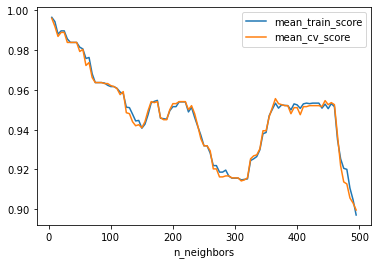

In [20]:
results_df.plot(x="n_neighbors", y=["mean_train_score", "mean_cv_score"])

In [21]:
results_df["train_cv_diff"] = results_df["mean_train_score"] - results_df["mean_cv_score"] 
results_df.head(20)

,n_neighbors,mean_train_score,mean_cv_score,std_cv_score,std_train_score,train_cv_diff
0,5,0.996470,0.995967,0.002016,0.001416,0.000503
1,10,0.994327,0.991927,0.005154,0.002955,0.002401
2,15,0.988023,0.986888,0.002478,0.001873,0.001135
3,20,0.989662,0.988907,0.002010,0.003028,0.000755
4,25,0.989662,0.988907,0.002010,0.003028,0.000755
5,30,0.985628,0.983859,0.004114,0.002858,0.001769
6,35,0.983863,0.983859,0.004114,0.001028,0.000004
7,40,0.983863,0.983859,0.004114,0.001028,0.000004
8,45,0.983863,0.983859,0.004114,0.001028,0.000004
9,50,0.981468,0.979313,0.009106,0.003073,0.002155


# Performance of Optimized Models

In [22]:
# KNN classifier with n_neighbors=20
k = 20
pipe_knn_tuned = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k))
results["KNN_tuned"] = mean_std_cross_val_scores(
    pipe_knn_tuned, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Dummy,KNN,SVM,LR,KNN_tuned
fit_time,0.003 (+/- 0.007),0.008 (+/- 0.008),0.026 (+/- 0.010),0.022 (+/- 0.009),0.012 (+/- 0.020)
score_time,0.007 (+/- 0.008),0.021 (+/- 0.009),0.016 (+/- 0.000),0.003 (+/- 0.007),0.028 (+/- 0.013)
test_accuracy,0.342 (+/- 0.019),0.996 (+/- 0.004),0.995 (+/- 0.003),0.997 (+/- 0.003),0.993 (+/- 0.005)
train_accuracy,0.331 (+/- 0.010),0.998 (+/- 0.001),0.995 (+/- 0.001),0.997 (+/- 0.001),0.993 (+/- 0.001)
test_f1_macro,0.342 (+/- 0.019),0.996 (+/- 0.004),0.995 (+/- 0.003),0.997 (+/- 0.003),0.993 (+/- 0.005)
train_f1_macro,0.331 (+/- 0.010),0.998 (+/- 0.001),0.995 (+/- 0.001),0.997 (+/- 0.001),0.993 (+/- 0.001)
test_recall_macro,0.342 (+/- 0.019),0.996 (+/- 0.004),0.995 (+/- 0.003),0.997 (+/- 0.003),0.993 (+/- 0.005)
train_recall_macro,0.331 (+/- 0.010),0.998 (+/- 0.001),0.995 (+/- 0.001),0.997 (+/- 0.001),0.993 (+/- 0.001)


In [23]:
# Save tuned KNN model to disk
filepath = '../../models/knn_tuned.model'
pipe_knn_tuned.fit(X_train, y_train)
pkl.dump(pipe_knn_tuned, open(filepath, 'wb'))

In [24]:
# Logistic Regression Classifier Model
pipe_lr_tuned = make_pipeline(StandardScaler(), LogisticRegression(C=100.0, solver='liblinear'))
results["LR_tuned"] = mean_std_cross_val_scores(
    pipe_lr_tuned, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Dummy,KNN,SVM,LR,KNN_tuned,LR_tuned
fit_time,0.003 (+/- 0.007),0.008 (+/- 0.008),0.026 (+/- 0.010),0.022 (+/- 0.009),0.012 (+/- 0.020),0.012 (+/- 0.007)
score_time,0.007 (+/- 0.008),0.021 (+/- 0.009),0.016 (+/- 0.000),0.003 (+/- 0.007),0.028 (+/- 0.013),0.006 (+/- 0.009)
test_accuracy,0.342 (+/- 0.019),0.996 (+/- 0.004),0.995 (+/- 0.003),0.997 (+/- 0.003),0.993 (+/- 0.005),0.992 (+/- 0.004)
train_accuracy,0.331 (+/- 0.010),0.998 (+/- 0.001),0.995 (+/- 0.001),0.997 (+/- 0.001),0.993 (+/- 0.001),0.993 (+/- 0.001)
test_f1_macro,0.342 (+/- 0.019),0.996 (+/- 0.004),0.995 (+/- 0.003),0.997 (+/- 0.003),0.993 (+/- 0.005),0.992 (+/- 0.004)
train_f1_macro,0.331 (+/- 0.010),0.998 (+/- 0.001),0.995 (+/- 0.001),0.997 (+/- 0.001),0.993 (+/- 0.001),0.993 (+/- 0.001)
test_recall_macro,0.342 (+/- 0.019),0.996 (+/- 0.004),0.995 (+/- 0.003),0.997 (+/- 0.003),0.993 (+/- 0.005),0.992 (+/- 0.004)
train_recall_macro,0.331 (+/- 0.010),0.998 (+/- 0.001),0.995 (+/- 0.001),0.997 (+/- 0.001),0.993 (+/- 0.001),0.993 (+/- 0.001)


In [25]:
# Save tuned logistic regression model to disk
filepath = '../../models/logistic_reg_tuned.model'
pipe_lr_tuned.fit(X_train, y_train)
pkl.dump(pipe_lr_tuned, open(filepath, 'wb'))

# Test Set prediction

In [26]:
# X, y split for test-set
test_df = pd.read_excel("../../data/processed/test_essentials.xlsx")
X_test, y_test = test_df.drop(columns=["Risk_Label"]), test_df["Risk_Label"]
X_testselect = X_test[select_features]

In [27]:
# Load saved model
pipe_lr_loaded = pkl.load(open('../../models/logistic_reg_tuned.model', 'rb'))
y_pred = pipe_lr_loaded.predict(X_testselect)

In [28]:
pipe_lr_loaded.score(X_testselect, y_test)

1.0